## Семинар 7: "Методы оптимизации"

ФИО:

In [92]:
import numpy as np
import torch
from torch import nn
from torch import functional as F
from torch.autograd import Variable

%matplotlib notebook
import seaborn
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [130]:
class Optimizer():
    def __init__(self, variables):
        self.variables = variables
        
    def step(self, loss):
        pass
    
class GD(Optimizer):
    def __init__(self, variables, learning_rate):
        super().__init__(variables)
        self.lr = learning_rate
        
    def step(self, J):
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v in self.variables:
                v -= self.lr * v.grad
                
                v.grad.data.zero_()
                
class Momentum(Optimizer):
    def __init__(self, variables, learning_rate, gamma=0.9):
        super().__init__(variables)
        self.lr = learning_rate
        self.g = gamma
        
        self.moments = []        
        for v in self.variables:
            self.moments.append(torch.zeros_like(v.data))
        
    def step(self, J):
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v, moment in zip(self.variables, self.moments):
                moment *= self.g
                moment += self.lr * v.grad
                
                v -= moment
                
                v.grad.data.zero_()
                
class NAG(Optimizer):
    def __init__(self, variables, learning_rate, gamma=0.9):
        super().__init__(variables)
        self.lr = learning_rate
        self.g = gamma
        
        self.moments = []        
        for v in self.variables:
            self.moments.append(torch.zeros_like(v.data))
        
    def step(self, J):
        with torch.no_grad():
            for v, moment in zip(self.variables, self.moments):
                moment *= self.g                
                v -= moment
        
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v, moment in zip(self.variables, self.moments):
                v += moment
                
                moment += self.lr * v.grad
                
                v -= moment
                
                v.grad.data.zero_()
                
class Adagrad(Optimizer):
    def __init__(self, variables, learning_rate, eps=10**-8):
        super().__init__(variables)
        self.lr = learning_rate
        self.eps = eps
        
        self.g_sq = []
        for v in self.variables:
            self.g_sq.append(torch.zeros_like(v.data))
        
    def step(self, J):
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v, g_sq in zip(self.variables, self.g_sq):      
                g_sq += v.grad**2
                v -= self.lr / (g_sq + self.eps).sqrt() * v.grad
                
                v.grad.data.zero_()

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [131]:
def apply_opt(optim, J, n_iters=1000):    
    points = []

    for i in range(n_iters):
        points.append((X.item(), Y.item(), J().item()))
        optim.step(J)

    points = np.array(points)
    return points

<IPython.core.display.Javascript object>


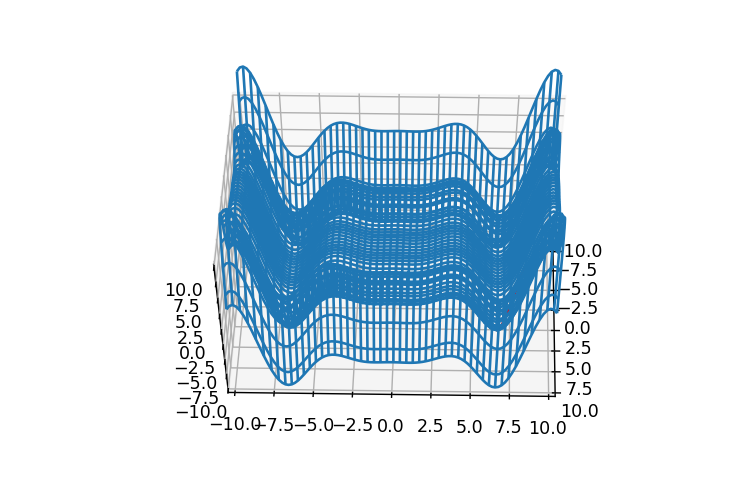

In [173]:
optims = [lambda v: GD(v, 0.1), lambda v: Momentum(v, 0.1),
          lambda v: NAG(v, 0.1), lambda v: Adagrad(v, 0.1)]

def J(X, Y):
    #return X**2/10 - Y**2/10
    return X**2/10 * X.sin() - Y**2/10 * Y.cos()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

R = 10
X = np.linspace(-R, R, 100)
Y = np.linspace(-R, R, 100)

ax.set_xlim3d(-R, +R)
ax.set_ylim3d(-R, +R)
ax.set_zlim3d(-R, +R)

xx, yy = np.meshgrid(X, Y)

xx = torch.from_numpy(xx)
yy = torch.from_numpy(yy)

Z = J(xx, yy)

#ax.plot(xx.numpy().flatten(), yy.numpy().flatten(), Z.numpy().flatten())
#ax.plot_surface(xx.numpy(), yy.numpy(), Z.numpy())
ax.plot_wireframe(xx.numpy(), yy.numpy(), Z.numpy())

for optim in [optims[-1]]:
    X = Variable(torch.tensor(float(8)), requires_grad=True)
    Y = Variable(torch.tensor(float(8)), requires_grad=True)    
    
    points = apply_opt(optim([X, Y]), lambda X=X, Y=Y: J(X, Y), 500)

    ax.plot(points[:, 0], points[:, 1], points[:, 2], c='red')

#plt.axis('equal')
plt.show()

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: